In [1]:
import torch
import normflows as nf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader as dl
import torchvision as tv

In [ ]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cuda')

In [ ]:
base = nf.distributions.DiagGaussian((784))

In [ ]:
def MAF_init():
    MAF_flows = []
    hidden = 512 #number of hidden units
    
    latent_size = 784 #input dimensions
    
    K=3

    for i in range(K):
        MAF_flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden)]
        MAF_flows += [nf.flows.Permute(2,mode="swap")]

    MAF_model = nf.NormalizingFlow(q0=base,flows=MAF_flows)

    return MAF_model

model = MAF_init()

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(f'model has {params} trainable parameters')

model has 6772352 trainable parameters


In [ ]:
transform = tv.transforms.Compose(
    [
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,),(0.5,)),
    ]   
)
batch_size =128

In [ ]:
trainset =tv.datasets.MNIST(root='./data',train=True,download=True,transform=transform)

trainloader = dl(trainset,batch_size=batch_size,shuffle=True)

In [ ]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6) 
tolerance = 0.0001
previous_loss = float('inf')
early_stop = False
losses = []
    
for epoch in tqdm(range(50)):
        model.train()
        for data,label in trainloader:
            optimizer.zero_grad()
            #data = data[0].to(device)  # Extract data from TensorDataset and move to device
            data = data[:, 0, :, :].flatten(start_dim=1).to(device)
            loss = model.forward_kld(data)
                
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optimizer.step()
                
            current_loss = loss.item()
                
            if epoch > 0:
                loss_diff = abs(current_loss - previous_loss)
                if loss_diff < tolerance:
                    early_stop = True
                    print(f"Early stopping at epoch {epoch+1} with loss difference {loss_diff:.6f}")
                    break
                
            losses.append(loss.item())
                
            previous_loss = current_loss
    
plt.figure()
plt.plot(losses)
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [1:23:00<3:47:36, 1241.47s/it]

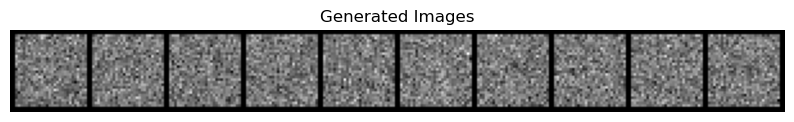

In [ ]:
def generate_and_print_images(model, device, num_images=5):
    model.eval()  

    with torch.no_grad():
        z = torch.randn(num_images, 784).to(device)  # Generate random noise of shape (num_images, 784)
        generated_images = model(z)  
    #generated_images = torch.clamp(generated_images,0,1)
    generated_images = generated_images.view(-1, 1, 28, 28)  
    generated_images = (generated_images * 0.5 )+ 0.5  # Denormalize images

    plt.figure(figsize=(10, 2))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(tv.utils.make_grid(generated_images.cpu(), nrow=num_images, normalize=True).permute(1, 2, 0))
    plt.show()

# Assuming your model has a `decoder` attribute that generates images based on noise `z`
model = model.to(device)

generate_and_print_images(model, device, num_images=10)


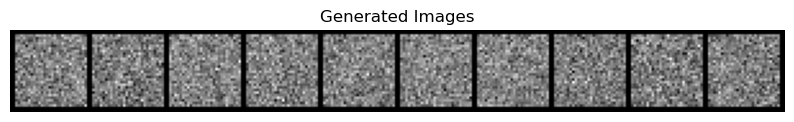

In [ ]:
def generate_and_print_images(model, device, num_images=5):
    model.eval()  

    with torch.no_grad():
        z = torch.randn(num_images, 784).to(device)  
        generated_images = model(z)  

        generated_images = generated_images.view(-1, 1, 28, 28)  #The error will be here
        generated_images = (generated_images * 0.5 )+ 0.5  # Denormalize images

    plt.figure(figsize=(10, 2))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(tv.utils.make_grid(generated_images.cpu(), nrow=num_images, normalize=True).permute(1, 2, 0))
    plt.show()

model = model.to(device)

generate_and_print_images(model, device, num_images=10)

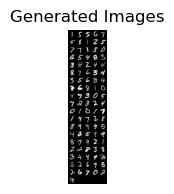

In [ ]:
for data,label in trainloader:
    data = data[:, 0, :, :].flatten(start_dim=1).to(device)
    generated_images = data 
    generated_images = generated_images.view(-1, 1, 28, 28)  
    generated_images = (generated_images * 0.5 )+ 0.5  # Denormalize images

plt.figure(figsize=(10, 2))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(tv.utils.make_grid(generated_images.cpu(), nrow=5, normalize=True).permute(1, 2, 0))
plt.show()